<font size=7>  $\textrm{Tutorial} \ 3$  </font>

<font size=5>  $\textrm{Supervised learning phase separation (2)}$   </font>



<font size=4>  $\textrm{We will try to learn the classification of phases into ferromagnetic/paramagnetic based on spin snapshots.}$   </font>

<font size=4>  $\textrm{Our goal: Train a machine learning model that will take in a spin configuration and tell us which phase it lives in for the Ising Hamiltonian.}$   </font>


<font size=5> $H = -J \sum_{\langle i, j \rangle}^{}  \sigma_i^z \sigma_{j}^z $</font>

<font size=5>  $\textrm{a) Preparing the data}$   </font>

<font size=4>  $\textrm{We import the samples generated into Python and set up our Pytorch data loaders}$   </font>

In [41]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

In [2]:
ferro_data = np.load("Data/Ising_2D_L30_T1.5_augm.npy")
para_data = np.load("Data/Ising_2D_L30_T5_augm.npy")

In [3]:
samples_ferro = ferro_data[0:7000]
samples_ferro_vali = ferro_data[7000:9000]
samples_ferro_test = ferro_data[9000:]

label_ferro = np.zeros(7000)
label_ferro_vali = np.zeros(2000)
label_ferro_test = np.zeros(1000)

In [4]:
samples_para = para_data[0:7000]
samples_para_vali = para_data[7000:9000]
samples_para_test = para_data[9000:]

label_para = np.ones(7000)
label_para_vali = np.ones(2000)
label_para_test = np.ones(1000)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [6]:
class SpinConfigurationDataset(Dataset):
    def __init__(self, spin_configs, labels):
        # Convert input data to tensors
        self.spin_configs = torch.tensor(spin_configs, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

        # Check for consistency in dataset lengths
        assert len(self.spin_configs) == len(self.labels), "Spin configurations and labels must have the same length"

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Add bounds checking
        if idx >= len(self.labels) or idx < 0:
            raise IndexError(f"Index {idx} is out of bounds for dataset with size {len(self.labels)}")
        
        spin_config = self.spin_configs[idx]
        label = self.labels[idx]
        return spin_config, label


In [7]:
training_data = torch.tensor(np.concatenate((samples_ferro,samples_para)))

In [8]:
training_labels = torch.tensor(np.concatenate((label_ferro,label_para )))

In [9]:
dataset = SpinConfigurationDataset(training_data, training_labels)

/tmp/ipykernel_3628818/3685099551.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.spin_configs = torch.tensor(spin_configs, dtype=torch.float32)
/tmp/ipykernel_3628818/3685099551.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long)


In [10]:
# Create data loader
batch_size = 500
shuffle = True
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [11]:
test_data = torch.tensor(np.concatenate((samples_ferro_test,samples_para_test)))

In [12]:
test_labels = torch.tensor(np.concatenate((label_ferro_test,label_para_test )))

In [13]:
test_data_loader = SpinConfigurationDataset(test_data, test_labels)

/tmp/ipykernel_3628818/3685099551.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.spin_configs = torch.tensor(spin_configs, dtype=torch.float32)
/tmp/ipykernel_3628818/3685099551.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long)


In [14]:
# Create data loader
batch_size = 500
shuffle = True
test_data_loader = DataLoader(test_data_loader, batch_size=batch_size, shuffle=shuffle)

In [15]:
vali_data = torch.tensor(np.concatenate((samples_ferro_vali,samples_para_vali)))

In [16]:
vali_labels = torch.tensor(np.concatenate((label_ferro_vali,label_para_vali )))

In [17]:
vali_data_loader = SpinConfigurationDataset(vali_data, vali_labels)

/tmp/ipykernel_3628818/3685099551.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.spin_configs = torch.tensor(spin_configs, dtype=torch.float32)
/tmp/ipykernel_3628818/3685099551.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long)


In [18]:
# Create data loader
batch_size = 500
shuffle = True
vali_data_loader = DataLoader(vali_data_loader, batch_size=batch_size, shuffle=shuffle)

In [174]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

# Define the neural network architecture
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.sigmoid(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(420)

In [175]:
# Define hyperparameters
input_size = ferro_data.shape[1]
hidden_size = 500
output_size = 2  # Number of classes
learning_rate = 0.001
num_epochs = 30

The `nn.CrossEntropyLoss` in PyTorch combines the operations of `nn.LogSoftmax` and `nn.NLLLoss` (negative log likelihood loss) in a single class. This is a commonly used loss function for classification tasks, particularly for multi-class classification (although ours is binary, but this work more generally for you to try stuff on your own!).

Here's a detailed explanation of how `nn.CrossEntropyLoss` works:

### Step-by-Step Breakdown

1. **Raw Model Outputs (Logits):**
   - Your neural network outputs raw scores, called logits, for each class. These logits are not probabilities and can take any value (positive or negative).
   - Let's denote the logits for a single sample as $\mathbf{z} = [z_1, z_2, \ldots, z_C]$, where $C$ is the number of classes.

2. **Softmax Function:**
   - The softmax function is applied to the logits to convert them into probabilities. The softmax function is defined as:
     <font size=4>$
     \sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}
     $</font>
   - This ensures that the output probabilities are in the range $[0, 1]$ and sum to $1$.

3. **Log-Softmax:**
   - Instead of applying the softmax function and then taking the logarithm, `nn.CrossEntropyLoss` directly computes the log-softmax. This is more numerically stable. The log-softmax for class \(i\) is defined as: 
     <font size=4>$
     \ \log(\sigma(\mathbf{z})_i) = z_i - \log\left(\sum_{j=1}^C e^{z_j}\right)
     $</font>

4. **Negative Log Likelihood Loss (NLLLoss):**
   - The loss for a single sample with true class label $y$ is given by:
     $
     \ \text{NLLLoss} = -\log(\sigma(\mathbf{z})_y)
     $
   - This corresponds to the negative log probability of the true class.

5. **Combining the Steps:**
   - `nn.CrossEntropyLoss` combines the log-softmax and NLLLoss steps into one function for efficiency. The final loss for a batch of samples is the average (or sum, depending on the settings) of the individual losses.

### Formula for Cross Entropy Loss
The cross-entropy loss for a single sample can be written as:
<font size=4>$\text{CrossEntropyLoss}(\mathbf{z}, y) = - \log\left(\frac{e^{z_y}}{\sum_{j=1}^C e^{z_j}}\right)$ </font>
where $z_y$ is the logit corresponding to the true class $y$.

For a batch of $N$ samples, the average cross-entropy loss is:
<font size=4>$
\text{CrossEntropyLoss}(\mathbf{Z}, \mathbf{y}) = -\frac{1}{N} \sum_{i=1}^N \log\left(\frac{e^{z_{i,y_i}}}{\sum_{j=1}^C e^{z_{i,j}}}\right)
$</font>
where $z_{i,y_i}$ is the logit for the $i$-th sample corresponding to its true class $y_i$.

### Practical Example in PyTorch

Here's how we typically implement it `nn.CrossEntropyLoss` in a PyTorch model:

In [178]:
# # Learning rate
# lr = 0.01
# # Alpha (smoothing constant)
# alpha = 0.2
# # Epsilon (term added to improve numerical stability)
# eps = 1e-8
# # Weight decay (L2 penalty)
# weight_decay = 0.2
# # Momentum
# momentum = 1
# # Centered (if True, computes the centered RMSProp, the gradient is normalized by an estimation of its variance)
# centered = False

# optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=alpha, eps=eps, weight_decay=weight_decay, momentum=momentum, centered=centered)

In [179]:
# Instantiate the model
model = FFNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
training_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    batch_losses = []  # Store batch losses for the current epoch
    for inputs, targets in data_loader:
        model.train()  # Ensure the model is in training mode

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_losses.append(loss.item())  # Append batch loss to the list

    training_losses.append(batch_losses)  # Append epoch's batch losses to the training_losses list

    # Validation
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    batch_val_losses = []  # Store validation batch losses for the current epoch
    with torch.no_grad():
        for inputs2, targets2 in temps_data_loader:#temps_data_loader:
            outputs = model(inputs2)
            loss = criterion(outputs, targets2)
            test_loss += loss.item()
            batch_val_losses.append(loss.item())  # Append validation batch loss to the list

    validation_losses.append(batch_val_losses)  # Append epoch's validation losses to the validation_losses list

    # Print average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader)}, Test Loss: {test_loss / len(temps_data_loader)}")


Epoch [1/30], Loss: 0.6771975776978901, Test Loss: 0.6714314058423042
Epoch [2/30], Loss: 0.6771975968565259, Test Loss: 0.6714314192533493
Epoch [3/30], Loss: 0.6771975776978901, Test Loss: 0.6714314192533493
Epoch [4/30], Loss: 0.6771975862128394, Test Loss: 0.6714314103126526
Epoch [5/30], Loss: 0.6771975776978901, Test Loss: 0.6714314118027687
Epoch [6/30], Loss: 0.6771976053714752, Test Loss: 0.6714314252138138


KeyboardInterrupt: 

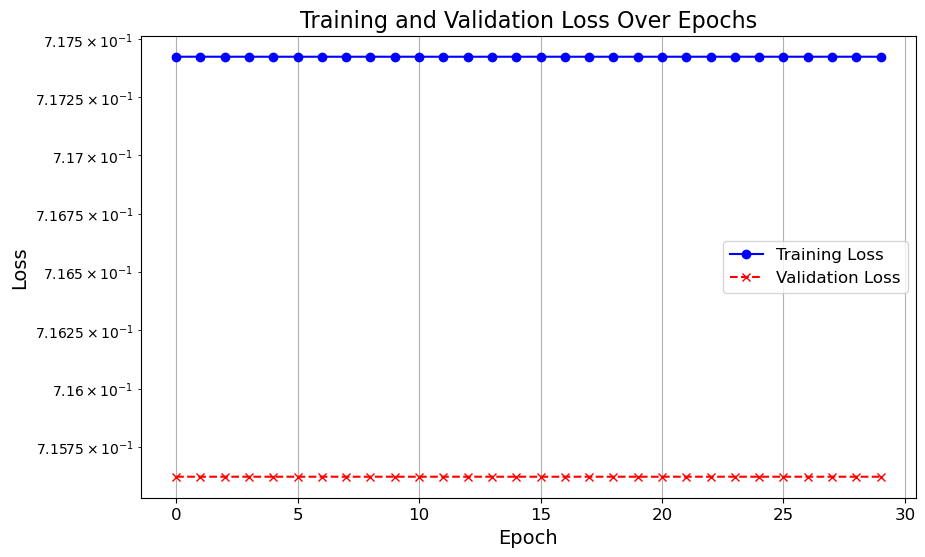

In [162]:
import matplotlib.pyplot as plt

# Assuming training_losses and validation_losses are already defined as lists of lists
# Flatten the lists to get the losses per epoch
avg_training_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in training_losses]
avg_validation_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in validation_losses]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and validation losses
plt.plot(avg_training_losses, label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(avg_validation_losses, label='Validation Loss', color='red', linestyle='--', marker='x')

# plt.axhline(test_loss / len(test_data_loader))

# Add title and labels with proper formatting
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

plt.yscale("log")
# Set tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot as an image file (optional)
plt.savefig('training_validation_loss_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


<font size=5>  $\textrm{Testing:}$   </font>

In [79]:
# Validation
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_data_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

In [80]:
print(f"Test Loss: {test_loss / len(test_data_loader)}")

Test Loss: 0.00010613975246087648


<font size=5>  $\textrm{Various temperatures}$   </font>

In [56]:
T05data = np.load("Data/Ising_2D_L30_T0.5.npy")
T05datalabel = np.zeros(5000)

T1data = np.load("Data/Ising_2D_L30_T1.npy")
T1datalabel = np.zeros(5000)

T10data = np.load("Data/Ising_2D_L30_T10.npy")
T10datalabel = np.ones(5000)

T3p2data = np.load("Data/Ising_2D_L30_T3.2.npy")
T3p2datalabel = np.ones(5000)

In [24]:
combined_data = np.vstack((T05data, T1data, T10data, T3p2data))
combined_labels = np.hstack((T05datalabel, T1datalabel, T10datalabel, T3p2datalabel))

In [57]:
temps_dataset = SpinConfigurationDataset(combined_data, combined_labels)

In [58]:
# Create data loader
batch_size = 500
shuffle = True
temps_data_loader = DataLoader(temps_dataset, batch_size=batch_size, shuffle=shuffle)

In [81]:
# Validation
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in temps_data_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

In [82]:
print(f"Test Loss: {test_loss / len(temps_data_loader)}")

Test Loss: 0.0009978395657526562


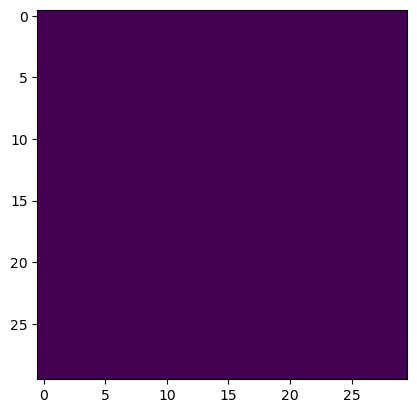

In [151]:
plt.imshow(np.reshape(T05data[500],(30,30)))

In [97]:
Tcritdata = np.load("Data/Ising_2D_L30_T2.6.npy")
Tcritdatalabel = np.zeros(5000)

In [98]:
crit_dataset = SpinConfigurationDataset(Tcritdata, Tcritdatalabel)

In [99]:
# Create data loader
batch_size = 500
shuffle = True
crit_data_loader = DataLoader(crit_dataset, batch_size=batch_size, shuffle=shuffle)

In [100]:
# Validation
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in crit_data_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

In [101]:
print(f"Test Loss: {test_loss / len(crit_data_loader)}")

Test Loss: 5.549159049987793
